# FEATURE ENGINEERING

## Import and load data

In [55]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns 

from pathlib import Path
from sklearn.preprocessing import StandardScaler, RobustScaler
from dateutil import parser


np.random.seed(42)

pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)
pd.set_option("display.width", None)
pd.set_option("display.max_colwidth", None)



In [2]:
df = pd.read_csv("../data/raw/creditcard.csv")
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


## TimeStamp Creation

In [3]:
base_time = pd.to_datetime("2024-01-01 00:00:00")


df["timestamp"] = base_time +  pd.to_timedelta(df['Time'])
df[['Time','timestamp']].head()

,Time,timestamp
0,0.0,2024-01-01 00:00:00.000000000
1,0.0,2024-01-01 00:00:00.000000000
2,1.0,2024-01-01 00:00:00.000000001
3,1.0,2024-01-01 00:00:00.000000001
4,2.0,2024-01-01 00:00:00.000000002


## Basic Time Feature

In [4]:
df["hour"] = df["timestamp"].dt.hour
df['dayofweek'] = df["timestamp"].dt.dayofweek

In [5]:
# check distribution

print("Hour distribution:")
print(df["hour"].value_counts().sort_index())

print("\nDay of week distribution:")
print(df["dayofweek"].value_counts().sort_index())


Hour distribution:
hour
0    284807
Name: count, dtype: int64

Day of week distribution:
dayofweek
0    284807
Name: count, dtype: int64


In [6]:
fraud_by_hour = df.groupby("hour")["Class"].mean() * 100
fraud_by_hour

hour
0    0.172749
Name: Class, dtype: float64

## Amount Transformations

### log transform

In [7]:
df["amount_log"] = np.log1p(df["Amount"])

df[["Amount", "amount_log"]].head()

,Amount,amount_log
0,149.62,5.014760
1,2.69,1.305626
2,378.66,5.939276
3,123.50,4.824306
4,69.99,4.262539


### Scaling

In [8]:
robust_scaler = RobustScaler()

df["amount_scaled"] = robust_scaler.fit_transform(df[['Amount']])

df[["Amount", "amount_log", "amount_scaled"]].head()

,Amount,amount_log,amount_scaled
0,149.62,5.014760,1.783274
1,2.69,1.305626,-0.269825
2,378.66,5.939276,4.983721
3,123.50,4.824306,1.418291
4,69.99,4.262539,0.670579


## Synthetic Categorical Augumentation

### merchant_id

In [9]:
n_merchants = 1000

merchants = np.arange(n_merchants)

weights = np.random.zipf(2, n_merchants)
prob = weights / weights.sum()

# assign merchants to each transaction
df["merchant_id"] = np.random.choice(merchants, size=len(df), p=prob)

df["merchant_id"].head()

0    606
1    270
2    606
3     65
4    606
Name: merchant_id, dtype: int64

### Device - types

In [10]:
device_types = ["mobile", "desktop", "pos", "tablet"]
device_probs = [0.60, 0.25, 0.10, 0.05]  # realistic traffic distribution

df["device_type"] = np.random.choice(device_types, size=len(df), p=device_probs)

df["device_type"].head()

0    desktop
1     mobile
2     mobile
3     mobile
4     mobile
Name: device_type, dtype: object

### geo_buckets

In [11]:
n_geo = 50

geo_buckets = np.arange(n_geo)

# slight skew (more users from lower buckets)
geo_weights = np.random.zipf(2, n_geo)
geo_prob = geo_weights / geo_weights.sum()

df["geo_bucket"] = np.random.choice(geo_buckets, size=len(df), p=geo_prob)

df["geo_bucket"].head()

0     0
1    38
2    14
3    14
4    14
Name: geo_bucket, dtype: int64

### acount_id

In [12]:
n_accounts = 10000  # realistic range 5k–20k

accounts = np.arange(n_accounts)

df["account_id"] = np.random.choice(accounts, size=len(df))

df["account_id"].head()

0    3963
1    1337
2    2406
3    6629
4    3579
Name: account_id, dtype: int64

### account_age_days

In [13]:
account_age_map = np.random.randint(0, 2000, size=n_accounts)

# map account age to each transaction
df["account_age_days"] = df["account_id"].map(dict(zip(accounts, account_age_map)))

df[["account_id", "account_age_days"]].head()

,account_id,account_age_days
0,3963,897
1,1337,1804
2,2406,550
3,6629,806
4,3579,42


In [14]:
# Cell 12: Validate distributions

print("Unique merchants:", df["merchant_id"].nunique())
print(df["merchant_id"].value_counts().head())

print("\nDevice types:")
print(df["device_type"].value_counts())

print("\nGeo buckets:", df["geo_bucket"].nunique())
print(df["geo_bucket"].value_counts().head())

print("\nAccounts:", df["account_id"].nunique())
print(df["account_id"].value_counts().head())

print("\nAccount age range:")
print(df["account_age_days"].min(), df["account_age_days"].max())


Unique merchants: 1000
merchant_id
606    77176
434    21780
788    12264
456     8998
960     6269
Name: count, dtype: int64

Device types:
device_type
mobile     170960
desktop     71250
pos         28344
tablet      14253
Name: count, dtype: int64

Geo buckets: 50
geo_bucket
34    73332
14    44361
40    30872
18    13783
23     8580
Name: count, dtype: int64

Accounts: 10000
account_id
5674    54
1957    52
1150    50
757     49
7698    48
Name: count, dtype: int64

Account age range:
0 1999


## Frequency Features

In [15]:
# merchant_freq

merchant_counts = df["merchant_id"].value_counts()

df["merchant_freq"] = df["merchant_id"].map(merchant_counts)

df[["merchant_id", "merchant_freq"]].head()

,merchant_id,merchant_freq
0,606,77176
1,270,52
2,606,77176
3,65,423
4,606,77176


In [16]:
# account_txn_count

account_counts = df["account_id"].value_counts()
df["account_txn_count"] = df["account_id"].map(account_counts)

df[["account_id", "account_txn_count"]].head()


,account_id,account_txn_count
0,3963,32
1,1337,27
2,2406,27
3,6629,33
4,3579,35


In [18]:
# device_freq

device_counts = df["device_type"].value_counts()
df["device_freq"] = df["device_type"].map(device_counts)

df[["device_type", "device_freq"]].head()


,device_type,device_freq
0,desktop,71250
1,mobile,170960
2,mobile,170960
3,mobile,170960
4,mobile,170960


In [21]:
df[["merchant_freq", "device_freq", "account_txn_count"]].describe()


,merchant_freq,device_freq,account_txn_count
count,284807.000000,284807.000000,284807.000000
mean,24226.435751,123980.149522,29.465564
std,32792.654281,59440.948131,5.283822
min,29.000000,14253.000000,10.000000
25%,353.000000,71250.000000,26.000000
50%,3605.000000,170960.000000,29.000000
75%,77176.000000,170960.000000,33.000000
max,77176.000000,170960.000000,54.000000


## Rolling Features - User recent behavior

In [23]:
## sorting by account_id + timestamp

df = df.sort_values(['account_id', 'timestamp']).reset_index(drop = True)

In [24]:
## rolling behavioral features

amount_shifted = df.groupby("account_id")["Amount"].shift(1)

df["last_5_mean_amount"] = amount_shifted.rolling(window = 5).mean()

# rolling count
df['last_5_count'] = amount_shifted.rolling(window = 5).count()

# fill NANs


df["last_5_mean_amount"] = df["last_5_mean_amount"].fillna(0)
df["last_5_count"] = df["last_5_count"].fillna(0)

df[["account_id", "Amount", "last_5_mean_amount", "last_5_count"]].head(10)

,account_id,Amount,last_5_mean_amount,last_5_count
0,0,10.45,0.000,0.0
1,0,15.16,0.000,0.0
2,0,56.85,0.000,0.0
3,0,1.00,0.000,0.0
4,0,14.58,0.000,4.0
5,0,93.04,19.608,5.0
6,0,72.64,36.126,5.0
7,0,38.03,47.622,5.0
8,0,1.99,43.858,5.0
9,0,212.50,44.056,5.0


## Categorical Encoding

In [28]:
cat_cols = ['merchant_id', 'device_type', 'geo_bucket', 'account_id']

encoders = {}

for col in cat_cols:

    freq = df[col].value_counts() / len(df)

    encoders[col] = freq.to_dict()

    df[col+ '_fe'] = df[col].map(encoders[col])

In [30]:
df[["merchant_id", "merchant_id_fe","account_id", "account_id_fe","geo_bucket", "geo_bucket_fe",
   "device_type", "device_type_fe"]].head()

,merchant_id,merchant_id_fe,account_id,account_id_fe,geo_bucket,geo_bucket_fe,device_type,device_type_fe
0,711,0.009645,0,0.000084,22,0.024030,mobile,0.600266
1,954,0.000783,0,0.000084,18,0.048394,mobile,0.600266
2,155,0.000786,0,0.000084,14,0.155758,desktop,0.250169
3,606,0.270976,0,0.000084,14,0.155758,mobile,0.600266
4,606,0.270976,0,0.000084,27,0.011734,pos,0.099520


## Interaction Features

In [37]:
df['amount_times_age'] = df["Amount"] *df["account_age_days"]

low_threshold = 100 # will tune later

df["is_new_merchant"] = (df["merchant_freq"] < low_threshold).astype(int)


df[["Amount", "account_age_days", "amount_times_age", "merchant_freq", "is_new_merchant"]].head()

,Amount,account_age_days,amount_times_age,merchant_freq,is_new_merchant
0,10.45,879,9185.55,2747,0
1,15.16,879,13325.64,223,0
2,56.85,879,49971.15,224,0
3,1.00,879,879.00,77176,0
4,14.58,879,12815.82,77176,0


In [39]:
df["amount_times_age"].describe()
df["is_new_merchant"].value_counts()


is_new_merchant
0    245914
1     38893
Name: count, dtype: int64

## Missing value Handling

In [41]:
cols_to_flag =  ["merchant_id", "device_type", "geo_bucket", "account_age_days"]

for col in cols_to_flag:
    df[col + "_missing"] = df[col].isna().astype(int)

df[[c for c in df.columns if c.endswith("_missing")]].head()

,merchant_id_missing,device_type_missing,geo_bucket_missing,account_age_days_missing
0,0,0,0,0
1,0,0,0,0
2,0,0,0,0
3,0,0,0,0
4,0,0,0,0


## PCA visualization

In [45]:
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
num_cols.remove("Class")

from sklearn.decomposition import PCA

pca = PCA(n_components = 2, random_state = 42)

pca_components = pca.fit_transform(df[num_cols])

df["pca_x"] = pca_components[:, 0]
df["pca_y"] = pca_components[:, 1]

df[["pca_x", "pca_y"]].head()


,pca_x,pca_y
0,-112202.379039,47085.867496
1,-106349.095127,47079.029197
2,-54582.505057,-52685.234510
3,-123980.606831,47143.713698
4,-107136.375683,-95476.911597


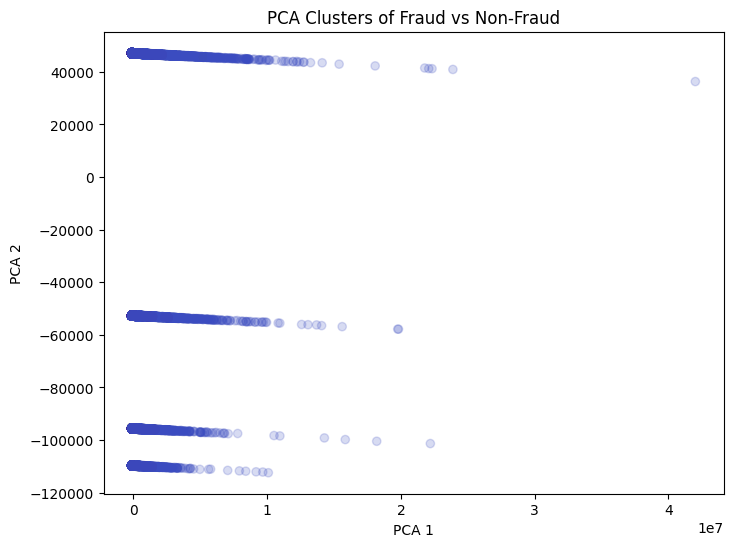

In [46]:
plt.figure(figsize=(8,6))
plt.scatter(df["pca_x"], df["pca_y"], c=df["Class"], alpha=0.2, cmap="coolwarm")
plt.title("PCA Clusters of Fraud vs Non-Fraud")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.show()


## IsolationForest Prototype(just a preview)

In [47]:
from sklearn.ensemble import IsolationForest

iso = IsolationForest(
    n_estimators=200,
    contamination="auto",
    random_state=42,
    n_jobs=-1
)

iso.fit(df[num_cols])

# anomaly_score: higher = more normal, lower = more anomalous
df["anomaly_score"] = iso.decision_function(df[num_cols])

# optional: also store binary anomaly prediction
df["is_anomaly"] = iso.predict(df[num_cols])  # -1 anomaly, 1 normal

df[["anomaly_score", "is_anomaly"]].head()

,anomaly_score,is_anomaly
0,0.093243,1
1,0.056649,1
2,0.073796,1
3,0.057151,1
4,0.052286,1


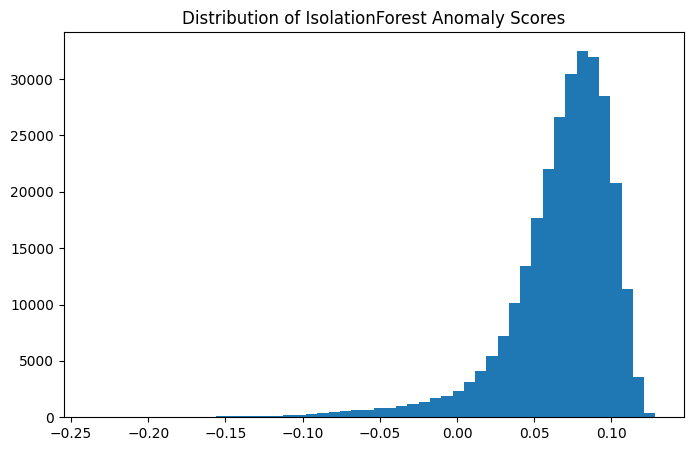

In [48]:
plt.figure(figsize=(8,5))
plt.hist(df["anomaly_score"], bins=50)
plt.title("Distribution of IsolationForest Anomaly Scores")
plt.show()


## Stratified Train/Test Split

In [49]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(
    df,
    test_size=0.2,
    stratify=df["Class"],
    random_state=42
)

print("Train shape:", train_df.shape)
print("Test shape: ", test_df.shape)

print("\nFraud ratio in train:", train_df["Class"].mean())
print("Fraud ratio in test: ", test_df["Class"].mean())


Train shape: (227845, 61)
Test shape:  (56962, 61)

Fraud ratio in train: 0.001729245759178389
Fraud ratio in test:  0.0017204452090867595


## Save Processed Data

In [52]:

train_df.to_csv("../data/processed/train.csv", index=False)
test_df.to_csv("../data/processed/test.csv", index=False)

print("Saved: data/processed/train.csv")
print("Saved: data/processed/test.csv")

Saved: data/processed/train.csv
Saved: data/processed/test.csv


## Final Feature list

In [53]:


print("Total columns:", len(df.columns))
print()

for col in df.columns:
    print(col, "-->", df[col].dtype)


Total columns: 61

Time --> float64
V1 --> float64
V2 --> float64
V3 --> float64
V4 --> float64
V5 --> float64
V6 --> float64
V7 --> float64
V8 --> float64
V9 --> float64
V10 --> float64
V11 --> float64
V12 --> float64
V13 --> float64
V14 --> float64
V15 --> float64
V16 --> float64
V17 --> float64
V18 --> float64
V19 --> float64
V20 --> float64
V21 --> float64
V22 --> float64
V23 --> float64
V24 --> float64
V25 --> float64
V26 --> float64
V27 --> float64
V28 --> float64
Amount --> float64
Class --> int64
timestamp --> datetime64[ns]
hour --> int32
dayofweek --> int32
amount_log --> float64
amount_scaled --> float64
merchant_id --> int64
device_type --> object
geo_bucket --> int64
account_id --> int64
account_age_days --> int32
merchant_freq --> int64
account_txn_count --> int64
device_freq --> int64
last_5_mean_amount --> float64
last_5_count --> float64
merchant_id_fe --> float64
device_type_fe --> float64
geo_bucket_fe --> float64
account_id_fe --> float64
amount_time_age --> float64

In [54]:
obj_cols = df.select_dtypes(include=['object']).columns.tolist()

leakage_cols = [
    "timestamp", "Time", "pca_x", "pca_y",
    "anomaly_score", "is_anomaly"
]

raw_cat_cols = ["merchant_id", "device_type", "geo_bucket", "account_id"]

print("Object columns:", obj_cols)
print("Raw categoricals:", raw_cat_cols)
print("Leakage columns:", leakage_cols)
print("\nNumeric features available:", len(df.select_dtypes(include=[np.number]).columns))


Object columns: ['device_type']
Raw categoricals: ['merchant_id', 'device_type', 'geo_bucket', 'account_id']
Leakage columns: ['timestamp', 'Time', 'pca_x', 'pca_y', 'anomaly_score', 'is_anomaly']

Numeric features available: 59


## Summary

Summary of Feature Engineering (Day 2) Ai generated obviously
1. Purpose
Built a realistic fraud-feature environment on top of the anonymized PCA dataset.
Added time, behavioral, frequency, rolling, categorical, and interaction features required for real-world fraud detection pipelines.


2. Major Feature Groups Added
A. Timestamp Features
	• Created synthetic timestamp from Time
	• Extracted hour, dayofweek
These allow temporal modeling and rolling behavior features.


B. Amount Transformations
	• amount_log to reduce skew
	• amount_scaled using StandardScaler for ML models


C. Synthetic Categorical Entities
Generated realistic fraud-relevant identifiers:
	• merchant_id (~1000 merchants)
	• device_type (mobile/desktop/pos/tablet)
	• geo_bucket (~50 synthetic regions)
	• account_id (10k accounts)
	• account_age_days (0–2000 days)
Purpose:
Simulate real merchant, device, geo, and user ecosystems since original data was PCA-stripped.


D. Frequency Features
For merchant, device, and account:
	• merchant_freq
	• device_freq
	• account_txn_count
Fraud risk correlates strongly with rarity and unusual frequency profiles.


E. Rolling Behavior Features
Computed per-account rolling patterns:
	• last_5_mean_amount
	• last_5_count
Models use these to identify bursts, spikes, and abnormal spending sequences.


F. Categorical Encodings
Frequency-encoded:
	• merchant_id_fe
	• device_type_fe
	• geo_bucket_fe
	• account_id_fe
These replace raw categorical fields and avoid one-hot dimensional explosion.


G. Interaction Features
	• amount_times_age = Amount * account_age_days
	• is_new_merchant based on merchant rarity
Captures nonlinear fraud patterns such as high-value transactions from new/young accounts or rare merchants.


H. Missingness Indicators
Added missing flags for categorical/age columns:
	• merchant_id_missing, device_type_missing, etc.
Missingness often carries predictive power in fraud systems.


I. PCA Visualization (2-component)
Created:
	• pca_x, pca_y
For evaluating structure and generating 2D fraud maps.
Not used for training.


J. IsolationForest Prototype
Generated:
	• anomaly_score
	• is_anomaly
Exploratory only.
Not used in classifiers.


3. Train/Test Split
Performed stratified split to preserve fraud ratio and ensure stable evaluation:
	• Saved to data/processed/train.csv
	• Saved to data/processed/test.csv
These files are the canonical dataset for all future modeling.


4. Schema Validation (Critical Findings)
Dropped columns (for Day 3):
	• Raw PCA components V1–V28
	• Raw categoricals (merchant_id, device_type, geo_bucket, account_id)
	• Time leakage (Time, timestamp)
	• Visualization fields (pca_x, pca_y)
	• Anomaly prototype fields (anomaly_score, is_anomaly)
	• Incorrect duplicate feature (amount_time_age)
Valid engineered features:
Behavioral, temporal, frequency, interaction, rolling, and encoded categorical features.


5. Outcome
Dataset is now structured like a real fraud-detection environment with:
	• user behavior sequences
	• merchant and device ecosystems
	• time-based patterns
	• rolling signals
	• interaction signals
	• encoded categorical variables
	• anomaly structure
